# Calculating $A_{\rm GWB}(t)$ for NANOGrav with `hasasia`
#### Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
import astropy.constants as c
import sys,os,glob,json,pickle,copy
from enterprise.pulsar import Pulsar as ePulsar

from astropy.time import Time as T

## Installation
I'm not actually sure that one needs enterprise installed if you are using a set of pickled enterprise.Pulsar objects, but let us know and we can send you installation instructions. I'm assuming most people who are looking at this already have it installed.

If you need to install `hasasia` then just use:
```
pip install hasasia
```

In [3]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky

Below we load a pickled list of enterprise pulsars. Making this list is the basic first step for all `enterprise` data analyses and and is included in most tutorials. Let me know if you need code to make this. 

In [64]:
# with open('./pickle_barrel/dsa2000_st_quo.pkl', 'rb') as fin:
#     psrs=pickle.load(fin)
with open('/Users/hazboun/pta_simulations/pta_simulations/data/pfc2019/tim_status_quo/pfc2019_status_quo_ePsrs.pkl', 'rb') as fin:
    psrs=pickle.load(fin)

Here we make a list of slices to do the analysis at. This goes from 8-40 years, but if one needs to see home many years of data there are in the data set you can use
```Python
hsen.get_Tspan(psrs)/(365.25*24*3600)

```

In [65]:
hsen.get_Tspan(psrs)/(365.25*24*3600)

39.999335824697525

In [66]:
Nyears = [8.0 + ii*1.0 for ii in range(33)][::-1]

In [67]:
Nyears

[40.0,
 39.0,
 38.0,
 37.0,
 36.0,
 35.0,
 34.0,
 33.0,
 32.0,
 31.0,
 30.0,
 29.0,
 28.0,
 27.0,
 26.0,
 25.0,
 24.0,
 23.0,
 22.0,
 21.0,
 20.0,
 19.0,
 18.0,
 17.0,
 16.0,
 15.0,
 14.0,
 13.0,
 12.0,
 11.0,
 10.0,
 9.0,
 8.0]

Set a list of amplitudes to calculate when we will reach the given SNR cutoff.

__Note__: If a `d` error is raised when you run the main script then you can set the initial `A_gwb` to be slightly higher. In order for the algorithm to work the first calculation must return an SNR>3. 

In [74]:
N_amps = 30
A_gwb = np.logspace(np.log10(3e-17),np.log10(4e-15),N_amps)
#If smallest A is too small, then SNR<3 and cutting the data won't help!!

In [75]:
A_gwb

array([3.00000000e-17, 3.55136250e-17, 4.20405853e-17, 4.97671193e-17,
       5.89136938e-17, 6.97412942e-17, 8.25588723e-17, 9.77321609e-17,
       1.15694110e-16, 1.36957242e-16, 1.62128271e-16, 1.91925420e-16,
       2.27198913e-16, 2.68955233e-16, 3.18385843e-16, 3.76901181e-16,
       4.46170906e-16, 5.28171541e-16, 6.25242868e-16, 7.40154691e-16,
       8.76185871e-16, 1.03721788e-15, 1.22784556e-15, 1.45350823e-15,
       1.72064487e-15, 2.03687789e-15, 2.41123058e-15, 2.85438462e-15,
       3.37898483e-15, 4.00000000e-15])

## Main Script

This script runs through the various amplitudes given above and, starting with the full data set, it continues to calculate SNR when a year of data is removed. When it reaches an SNR<`snr_cutoff` it then moves on to the next amplitude. It "intelligently" tries to make an educated guess of which slice to start with, as not to waste time. 

In [76]:
results = np.zeros((N_amps,5))
curves = []
IDX = 0

# This thinning option is for using real channelized NANOGrav data.
# One does not need 55 TOAs from a given epoch to calculate the sensitivity
# Try starting with thin = 10 in that case. 
# For simulated data sets, thin = 1 is fine. (i.e. it won't thin)
thin = 1

#Set SNR cutoff, usually 3.0
snr_cutoff = 3.0

#If rerunning this try, except gets used to delete old cutoff values. 
try:
    del old_cutoff, old_snr
except NameError:
    pass

old_pnames=[]
for jj, amp in enumerate(A_gwb):
    print('!!!Looking at A_gwb={0:1.2e}'.format(amp))
    
    # Make a new copy of the list of pickled enterprise.Pulsar objects for the new amplitude.
    psrs_copy = copy.deepcopy(psrs)
    start_mjd = np.amin([p.toas.min() for p in psrs_copy])/(24*3600)
    
    #This buffers the iterative start value so you don't skip to a value <snr_cutoff.
    if IDX == 0:
        idx_use = IDX
    else:
        idx_use = IDX - 1
        
    
    for yr in Nyears[idx_use:]:
        #Calculate the time span and frequencies for slicing
        tspan = yr*365.25*24*3600
        freqs = np.linspace(1/tspan,30/tspan,30)
        Psrs = []
        cutoff = start_mjd + yr*365.25
        print("Cutoff: ",cutoff)
        #Filter pulsars by timespan and add GWB as autocorrelated RN
        idxs = []
        for idx, ePsr in enumerate(psrs_copy):
            #Cut the data to the requested length
            ePsr.filter_data(start_time=start_mjd, end_time=cutoff)
            
            #Make a simple diagonal correlation matrix
            corr = np.diag(ePsr.toaerrs[::thin]**2)
            # Add autocorrelation noise from GWB into pulsar
            plaw = hsen.red_noise_powerlaw(A=amp, gamma=13/3., 
                                           freqs=freqs)
            corr += hsen.corr_from_psd(freqs=freqs, psd=plaw,
                                  toas=ePsr.toas[::thin])
            
            #Make hasasia.Pulsar object
            psr = hsen.Pulsar(toas=ePsr.toas[::thin],
                              toaerrs=ePsr.toaerrs[::thin],
                              phi=ePsr.phi,theta=ePsr.theta,
                              designmatrix=ePsr.Mmat[::thin,:],
                              N=corr)
            #Keep the name 
            psr.name = ePsr.name
            
            #If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
            if (psr.toas.size ==0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
                idxs.append(idx)
                pass
            else:
                Psrs.append(psr)
            
            print('\rAdd PSR {0} complete '.format(ePsr.name),
                  end='',flush=True)
            
        # Get the list of pulsars before the cut
        pnames = [p.name for p in Psrs]
        
        #Remove pulsars with less than 3 years of data
        for idx in reversed(idxs):
            del psrs_copy[idx]
        
        # List number of pulsars that made the cut
        print('. --> {0} Pulsars'.format(len(Psrs)))
        
        # These help in debugging if needed. 
#         if len(old_pnames) < len(pnames):
#             print([nm for nm in old_pnames if nm not in pnames])
#         old_pnames = pnames   
        
        # Make the individual hasasia.Spectrum objects
        spectra = []
        for p in Psrs:
            sp = hsen.Spectrum(p, freqs=freqs)
            sp.NcalInv #This line is what takes most of the computation time.
            spectra.append(sp)
            print('\rSpectra for PSR {0} complete '.format(p.name),
                  end='', flush=True)
        
        # Calculate the stochastic sensitivity curve
        curv = hsen.GWBSensitivityCurve(spectra)
        
        # Make a power-law spectrum using the given amplitude and calculate the SNR
        Sh = hsen.S_h(amp, -2/3. ,freqs)
        snr = curv.SNR(Sh)
        
        if snr < snr_cutoff:
            try: # This will only work if there is an old SNR
                results[jj,:] = amp,cutoff,snr,old_cutoff,old_snr
            except NameError:
                if IDX == 0:
                    err_msg = 'Initial A_GWB={0:1.2e} too low!!'.format(amp)
                    err_msg += '\nReturns SNR={0:1.2f}.'.format(snr)
                    err_msg += '\nMust enter a higher value for lowest A_GWB value'
                    raise ValueError(err_msg)
                else:
                    IDX = Nyears.index(yr) - 1
                    break
            curves.append(curv)
            IDX = Nyears.index(yr)
            print('\n***Year {0} complete. SNR={1:1.2f}'.format(yr,snr))
            print('\n')
            break
        else:
            old_cutoff = cutoff
            old_snr = snr
            print('\n***Year {0} complete. SNR={1:1.2f}'.format(yr,snr))
        
    try:
        del old_cutoff, old_snr
    except NameError:
        pass

!!!Looking at A_gwb=3.00e-17
Cutoff:  67980.99515398039
Add PSR J2302+4442 complete ete . --> 56 Pulsars
Spectra for PSR J2302+4442 complete ete 
***Year 40.0 complete. SNR=3.01
Cutoff:  67615.74515398039
Add PSR J2302+4442 complete ete . --> 56 Pulsars
Spectra for PSR J2302+4442 complete ete 
***Year 39.0 complete. SNR=2.83


!!!Looking at A_gwb=3.55e-17
Cutoff:  67980.99515398039
Add PSR J2302+4442 complete ete . --> 56 Pulsars
Spectra for PSR J2302+4442 complete ete 
***Year 40.0 complete. SNR=3.42
Cutoff:  67615.74515398039
Add PSR J2302+4442 complete ete . --> 56 Pulsars
Spectra for PSR J2302+4442 complete ete 
***Year 39.0 complete. SNR=3.22
Cutoff:  67250.49515398039
Add PSR J2302+4442 complete ete . --> 56 Pulsars
Spectra for PSR J2302+4442 complete ete 
***Year 38.0 complete. SNR=3.02
Cutoff:  66885.24515398039
Add PSR J2302+4442 complete ete . --> 56 Pulsars
Spectra for PSR J2302+4442 complete ete 
***Year 37.0 complete. SNR=2.82


!!!Looking at A_gwb=4.20e-17
Cutoff:  67250.

Add PSR J2145-0750 complete ete . --> 45 Pulsars
Spectra for PSR J2145-0750 complete ete 
***Year 21.0 complete. SNR=3.31
Cutoff:  60675.995153980395
Add PSR J2145-0750 complete ete . --> 44 Pulsars
Spectra for PSR J2145-0750 complete ete 
***Year 20.0 complete. SNR=2.86


!!!Looking at A_gwb=5.28e-16
Cutoff:  61041.245153980395
Add PSR J2302+4442 complete ete . --> 45 Pulsars
Spectra for PSR J2145-0750 complete ete 
***Year 21.0 complete. SNR=3.66
Cutoff:  60675.995153980395
Add PSR J2145-0750 complete ete . --> 44 Pulsars
Spectra for PSR J2145-0750 complete ete 
***Year 20.0 complete. SNR=3.17
Cutoff:  60310.745153980395
Add PSR J2145-0750 complete ete . --> 40 Pulsars
Spectra for PSR J2145-0750 complete ete 
***Year 19.0 complete. SNR=2.71


!!!Looking at A_gwb=6.25e-16
Cutoff:  60675.995153980395
Add PSR J2302+4442 complete ete . --> 44 Pulsars
Spectra for PSR J2145-0750 complete ete 
***Year 20.0 complete. SNR=3.50
Cutoff:  60310.745153980395
Add PSR J2145-0750 complete ete . --> 

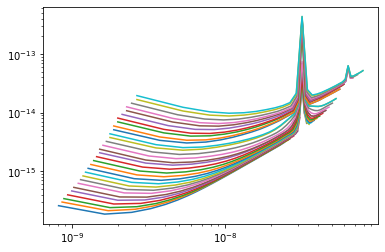

In [77]:
# We keep all of the sensitivity curves as a visual check
# Note that the frequency coverage of the 30 frequencies changes over time. 
for curv in curves:
    plt.loglog(curv.freqs,curv.h_c)
    
# plt.ylim(4e-16,1e-15)
plt.show()

Here we do a linear interpolation by hand to calculate when the threshold on the SNR is crossed. If for some reason the plot below isn't smooth enough, one could use a finer set of years at which to slice.

In [78]:
time_detection = []
for row in results:
    x1,y1 = row[[1,2]]
    x2,y2 = row[[3,4]]
    m = (y2-y1)/(x2-x1)
    x = (3-y1)/m
    time_detection.append([x+x1,row[0]])
    
time_detection = np.array(time_detection) 

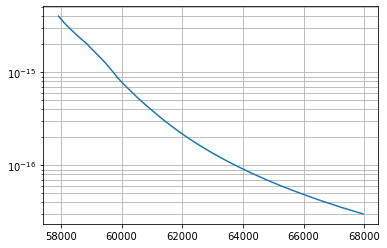

In [79]:
plt.semilogy(time_detection[:,0],time_detection[:,1])
plt.grid(which='both')
plt.show()

Save the file to a text file if you wish.

In [32]:
# np.savetxt('dsa2000_190520_status_quo_sens_curv.txt',
#            np.array((yrs[::-1],time_detection[:,1][::-1])).T,
#            fmt='%4.3f, %1.2e')

In [34]:
# stat=np.loadtxt('dsa2000_190520_status_quo_sens_curv.txt',delimiter=',')

Below are the red noise values for the pulsars that were found to have significant amounts of red noise in the 11-year data paper.

In [45]:
rn_psrs = {'B1855+09':[10**-13.7707, 3.6081],
           'B1937+21':[10**-13.2393, 2.46521],
           'J0030+0451':[10**-14.0649, 4.15366],
           'J0613-0200':[10**-13.1403, 1.24571],
           'J1012+5307':[10**-12.6833, 0.975424],
           'J1643-1224':[10**-12.245, 1.32361],
           'J1713+0747':[10**-14.3746, 3.06793],
           'J1747-4036':[10**-12.2165, 1.40842],
           'J1903+0327':[10**-12.2461, 2.16108],
           'J1909-3744':[10**-13.9429, 2.38219],
           'J2145-0750':[10**-12.6893, 1.32307],
           }

Here the best guess for the smallest amplitude is a bit bigger since we are injecting red noise. I have iterated on this particular data set, so I knew what to put. The code will error if you haven't gone high enough. If you go too low the first amplitude might take a bit longer, but it will be faster after that.

In [46]:
A_gwb2 = np.logspace(np.log10(1.5e-17),np.log10(1.5e-15),N_amps)

There is only one small difference in this code where the red noise from above is injected on top of the GWB. 

In [47]:
results2 = np.zeros((N_amps,5))
curves2 = []
IDX = 0

# This thinning option is for using real channelized NANOGrav data.
# One does not need 55 TOAs from a given epoch to calculate the sensitivity
# Try starting with thin = 10 in that case. For simulated data sets, thin = 1 is fine. (It won't thin)
thin = 1

#Set SNR cutoff, usually 3.0
snr_cutoff = 3.0

#If rerunning this try, except gets used to delete old cutoff values. 
try:
    del old_cutoff, old_snr
except NameError:
    pass

old_pnames=[]
for jj, amp in enumerate(A_gwb2):
    print('!!!Looking at A_gwb={0:1.2e}'.format(amp))
    
    # Make a new copy of the list of pickled enterprise.Pulsar objects for the new amplitude.
    psrs_copy = copy.deepcopy(psrs)
    start_mjd = np.amin([p.toas.min() for p in psrs_copy])/(24*3600)
    
    #This buffers the iterative start value so you don't skip to a value <snr_cutoff.
    if IDX == 0:
        idx_use = IDX
    else:
        idx_use = IDX - 1
        
    
    for yr in Nyears[idx_use:]:
        #Calculate the time span and frequencies for slicing
        tspan = yr*365.25*24*3600
        freqs = np.linspace(1/tspan,30/tspan,30)
        Psrs = []
        cutoff = start_mjd + yr*365.25
        print("Cutoff: ",cutoff)
        #Filter pulsars by timespan and add GWB as autocorrelated RN
        idxs = []
        for idx, ePsr in enumerate(psrs_copy):
            #Cut the data to the requested length
            ePsr.filter_data(start_time=start_mjd, end_time=cutoff)
            
            #Make a simple diagonal correlation matrix
            corr = np.diag(ePsr.toaerrs[::thin]**2)
            # Add autocorrelation noise from GWB into pulsar
            plaw = hsen.red_noise_powerlaw(A=amp, gamma=13/3., freqs=freqs)
            corr += hsen.corr_from_psd(freqs=freqs, psd=plaw,
                                  toas=ePsr.toas[::thin])
            
            #!!!!! Only main difference between the scripts !!!!!!
            # Add RN to the pulsars that are in the list from the 11-year data paper
            if ePsr.name in rn_psrs.keys():
                Amp, gam = rn_psrs[ePsr.name]
                plaw = hsen.red_noise_powerlaw(A=Amp, gamma=gam, freqs=freqs)
                corr += hsen.corr_from_psd(freqs=freqs, psd=plaw,
                                           toas=ePsr.toas[::thin])
            
            #Make hasasia.Pulsar object
            psr = hsen.Pulsar(toas=ePsr.toas[::thin],
                              toaerrs=ePsr.toaerrs[::thin],
                              phi=ePsr.phi,theta=ePsr.theta,
                              designmatrix=ePsr.Mmat[::thin,:],
                              N=corr)
            #Keep the name 
            psr.name = ePsr.name
            
            #If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
            if (psr.toas.size ==0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
                idxs.append(idx)
                pass
            else:
                Psrs.append(psr)
            
            print('\rAdd PSR {0} complete '.format(ePsr.name),
                  end='',flush=True)
            
        # Get the list of pulsars before the cut
        pnames = [p.name for p in Psrs]
        
        #Remove pulsars with less than 3 years of data
        for idx in reversed(idxs):
            del psrs_copy[idx]
        
        # List number of pulsars that made the cut
        print('. --> {0} Pulsars'.format(len(Psrs)))
        
        # These help in debugging if needed. 
#         if len(old_pnames) < len(pnames):
#             print([nm for nm in old_pnames if nm not in pnames])
#         old_pnames = pnames   
        
        # Make the individual hasasia.Spectrum objects
        spectra = []
        for p in Psrs:
            sp = hsen.Spectrum(p, freqs=freqs)
            sp.NcalInv #This line is what takes most of the computation time.
            spectra.append(sp)
            print('\rSpectra for PSR {0} complete '.format(p.name),
                  end='', flush=True)
        
        # Calculate the stochastic sensitivity curve
        curv = hsen.GWBSensitivityCurve(spectra)
        
        # Make a power-law spectrum using the given amplitude and calculate the SNR
        Sh = hsen.S_h(amp, -2/3. ,freqs)
        snr = curv.SNR(Sh)
        
        if snr < snr_cutoff:
            try: # This will only work if there is an old SNR
                results2[jj,:] = amp,cutoff,snr,old_cutoff,old_snr
            except NameError:
                if IDX == 0:
                    err_msg = 'Initial A_GWB={0:1.2e} too low!!'.format(amp)
                    err_msg += '\nReturns SNR={0:1.2f}.'.format(snr)
                    err_msg += '\nMust enter a higher value for lowest A_GWB value'
                    raise ValueError(err_msg)
                else:
                    IDX = Nyears.index(yr) - 1
                    break
            curves2.append(curv)
            IDX = Nyears.index(yr)
            print('\n***Year {0} complete. SNR={1:1.2f}'.format(yr,snr))
            print('\n')
            break
        else:
            old_cutoff = cutoff
            old_snr = snr
            print('\n***Year {0} complete. SNR={1:1.2f}'.format(yr,snr))
        
    try:
        del old_cutoff, old_snr
    except NameError:
        pass

!!!Looking at A_gwb=1.50e-17
Cutoff:  67980.99543677893
Add PSR J2322+2057 complete . --> 157 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 40.0 complete. SNR=3.18
Cutoff:  67615.74543677893
Add PSR J2322+2057 complete . --> 157 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 39.0 complete. SNR=2.88


!!!Looking at A_gwb=1.76e-17
Cutoff:  67980.99543677893
Add PSR J2322+2057 complete . --> 157 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 40.0 complete. SNR=3.78
Cutoff:  67615.74543677893
Add PSR J2322+2057 complete . --> 157 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 39.0 complete. SNR=3.43
Cutoff:  67250.49543677893
Add PSR J2322+2057 complete . --> 155 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 38.0 complete. SNR=3.10
Cutoff:  66885.24543677893
Add PSR J2322+2057 complete . --> 150 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 37.0 complete. SNR=2.79


!!!Looking at A_gwb=2.06e-17
Cutoff:  67250.49543677893
Add PSR J2322+2057 complete . 

Add PSR J2322+2057 complete . --> 84 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 20.0 complete. SNR=2.95


!!!Looking at A_gwb=2.61e-16
Cutoff:  61041.24543677893
Add PSR J2322+2057 complete . --> 87 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 21.0 complete. SNR=3.97
Cutoff:  60675.99543677893
Add PSR J2322+2057 complete . --> 84 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 20.0 complete. SNR=3.36
Cutoff:  60310.74543677893
Add PSR J2322+2057 complete . --> 78 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 19.0 complete. SNR=2.81


!!!Looking at A_gwb=3.07e-16
Cutoff:  60675.99543677893
Add PSR J2322+2057 complete . --> 84 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 20.0 complete. SNR=3.80
Cutoff:  60310.74543677893
Add PSR J2322+2057 complete . --> 78 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 19.0 complete. SNR=3.20
Cutoff:  59945.49543677893
Add PSR J2322+2057 complete . --> 76 Pulsars
Spectra for PSR J2322+2057 complete 
***Year 18

In [35]:
time_detection2 = []
for row in results2:
    x1,y1 = row[[1,2]]
    x2,y2 = row[[3,4]]
    m = (y2-y1)/(x2-x1)
    x = (3-y1)/m
    time_detection2.append([x+x1,row[0]])
    
time_detection2 = np.array(time_detection2) 

NameError: name 'results2' is not defined

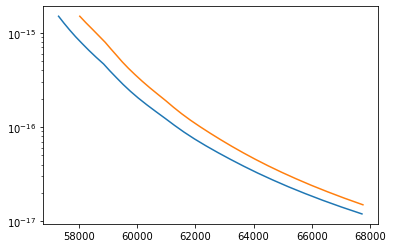

In [50]:
plt.semilogy(time_detection[:,0],time_detection[:,1])
plt.semilogy(time_detection2[:,0],time_detection2[:,1])
plt.show()

In [51]:
mjd = start_mjd + np.array(Nyears)*365.25
yrs_mjd = T(time_detection[:,0],format='mjd')
yrs=yrs_mjd.decimalyear
yrs_mjd2 = T(time_detection2[:,0],format='mjd')
yrs2=yrs_mjd2.decimalyear

In [41]:
# np.savetxt('dsa2000_190520_status_quo_sens_curv_wRN.txt',
#            np.array((yrs4[::-1],time_detection4[:,1][::-1])).T,
#            fmt='%4.3f %1.2e')

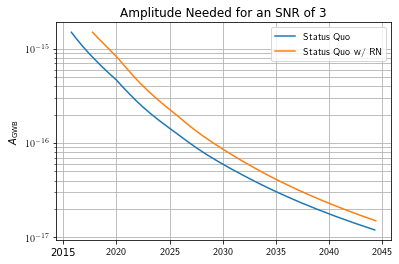

In [52]:
plt.semilogy(yrs, time_detection[:,1],label='Status Quo')
plt.semilogy(yrs2, time_detection2[:,1],label='Status Quo w/ RN',
             linestyle='-',color='C1')
plt.title('Amplitude Needed for an SNR of 3')
plt.grid(which='both')
# plt.xlim(2015,2040)
# plt.ylim(9e-17,2e-15)
plt.rc('text', usetex=True)
plt.ylabel('Year')
plt.ylabel(r'$A_{\rm GWB}$')
plt.legend(loc='upper right')
# plt.savefig('./amplitude_time_NG.pdf',bbox='tight',dpi=400)
plt.show()